In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import lightgbm as lgb
import warnings
import shap
import gc
import traceback
import networkx as nx
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from collections import Counter
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')

c:\Users\brian\miniconda3\envs\ipopt-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargamos los datos para un análisis inicial
sales =  pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

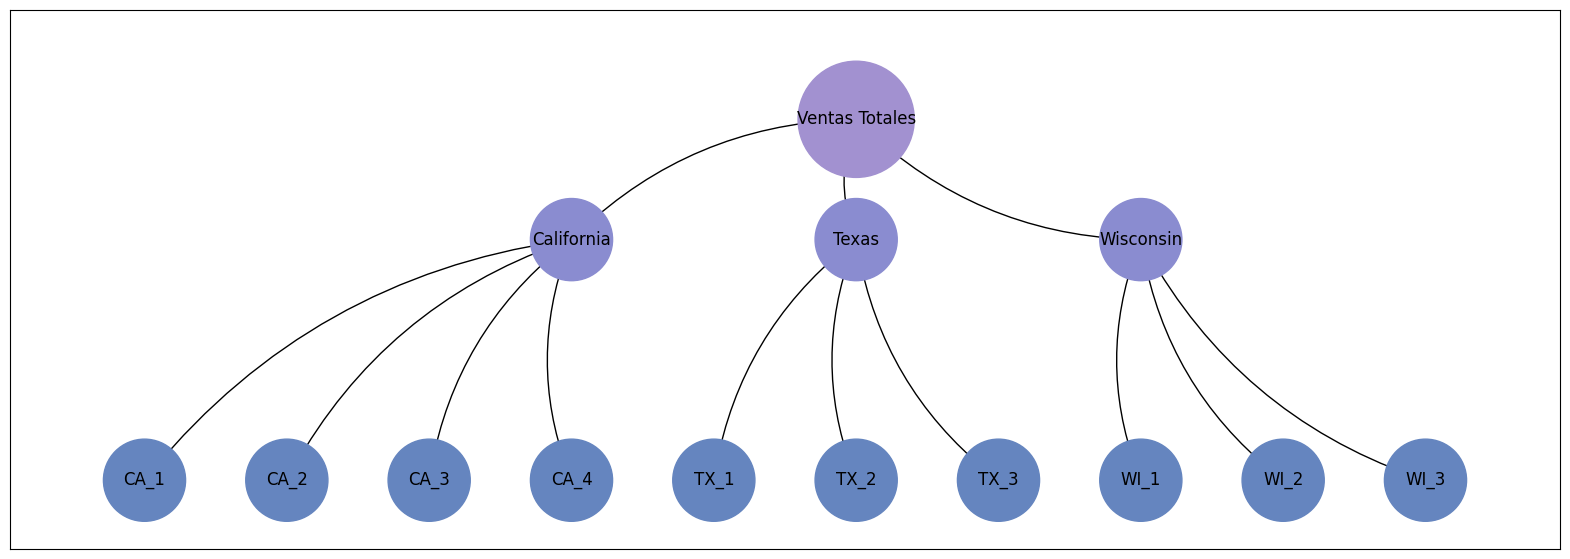

In [3]:
colorq="#10263B"
colorp = "#A291D0"
periodos=28
G = nx.DiGraph()
nodes = [
    "Ventas Totales", "California", "Texas", "Wisconsin",
    "CA_1", "CA_2", "CA_3", "CA_4",
    "TX_1", "TX_2", "TX_3",
    "WI_1", "WI_2", "WI_3"
]
G.add_nodes_from(nodes)
edges = [
    ("Ventas Totales", "California"), ("Ventas Totales", "Texas"), ("Ventas Totales", "Wisconsin"),
    ("California", "CA_1"), ("California", "CA_2"), ("California", "CA_3"), ("California", "CA_4"),
    ("Texas", "TX_1"), ("Texas", "TX_2"), ("Texas", "TX_3"),
    ("Wisconsin", "WI_1"), ("Wisconsin", "WI_2"), ("Wisconsin", "WI_3"),
]
G.add_edges_from(edges)

pos = {
    "Ventas Totales": (0, 3),
    "California": (-2, 2.5), "Texas": (0, 2.5), "Wisconsin": (2, 2.5),
    "CA_1": (-5, 1.5), "CA_2": (-4, 1.5), "CA_3": (-3, 1.5), "CA_4":(-2,1.5),
    "TX_1": (-1, 1.5), "TX_2": (0, 1.5), "TX_3": (1, 1.5),
    "WI_1": (2, 1.5), "WI_2": (3, 1.5), "WI_3": (4, 1.5),
}

node_color = [
    colorp if node == "Ventas Totales" else
    "#8a8cd0" if node in ["California", "Texas", "Wisconsin"] else
    "#6585bf"
    for node in G.nodes
]

plt.figure(figsize=(20, 7))
nx.draw_networkx_nodes(
    G, pos,
    node_size=[7000 if node == "Ventas Totales" else 3500 for node in G.nodes],
    node_color=node_color
)
nx.draw_networkx_labels(G, pos, font_color="black")
nx.draw_networkx_edges(
    G, pos,
    connectionstyle="arc3,rad=0.2",
    edge_color="black"
)

plt.show()


In [4]:
id_vars = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
sales_long = sales.melt(
    id_vars=id_vars,
    var_name="d",
    value_name="sales"
)
sales_long = sales_long[sales_long["sales"].notna() & (sales_long["sales"] >= 0)]
sales_long = sales_long[sales_long["id"].str.contains("validation")]
sales_long["sales"] = sales_long["sales"].astype("uint16")


calendar["date"] = pd.to_datetime(calendar["date"])
event_cols = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
calendar[event_cols] = calendar[event_cols].fillna("No Event")
calendar["weekday"] = calendar["weekday"].astype("category")

snap_cols = ["snap_CA", "snap_TX", "snap_WI"]
calendar[snap_cols] = calendar[snap_cols].astype("bool")


prices = prices.drop_duplicates(
    subset=["store_id", "item_id", "wm_yr_wk"],
    keep="last"
)
prices["sell_price"] = prices.groupby(["store_id", "item_id"])["sell_price"].transform(
    lambda x: x.fillna(x.median())
)
prices = prices.dropna(subset=["sell_price"])
prices["sell_price"] = prices["sell_price"].astype("float32")


df_merged = sales_long.merge(
    calendar[["d", "date", "wm_yr_wk", "event_name_1", "snap_CA"]],
    on="d",
    how="left"
)
df_final = df_merged.merge(
    prices,
    on=["store_id", "item_id", "wm_yr_wk"],
    how="left"
)

In [5]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,No Event,No Event,No Event,No Event,False,False,False
1,2011-01-30,11101,Sunday,2,1,2011,d_2,No Event,No Event,No Event,No Event,False,False,False
2,2011-01-31,11101,Monday,3,1,2011,d_3,No Event,No Event,No Event,No Event,False,False,False
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,No Event,No Event,No Event,No Event,True,True,False
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,No Event,No Event,No Event,No Event,True,False,True


In [7]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


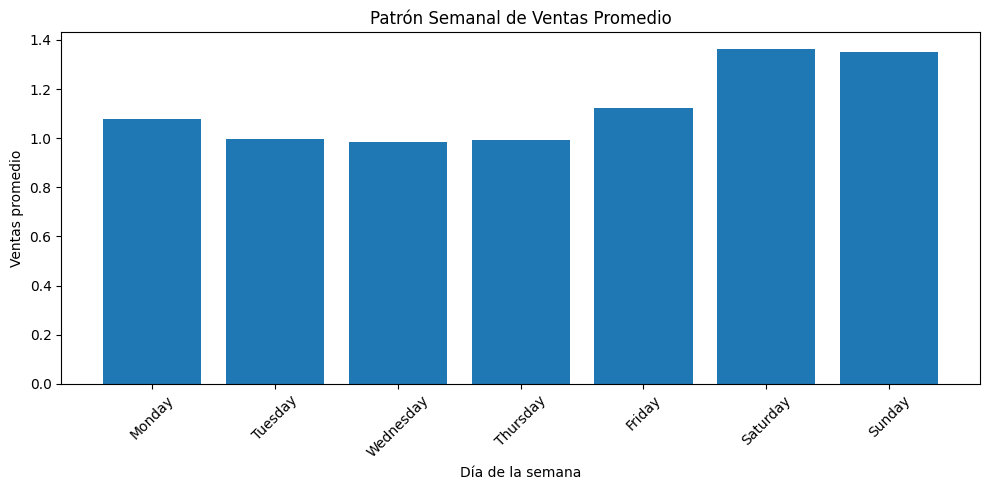

In [8]:
# Preparar datos para visualización
d_columns = [col for col in sales.columns if col.startswith('d_')]
sales_melted = sales.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
    value_vars=d_columns,
    var_name='d', 
    value_name='sales'
)

# Unir con calendario
sales_melted['d_num'] = sales_melted['d'].str.extract('(\d+)').astype(int)
calendar['d_num'] = calendar['d'].str.extract('(\d+)').astype(int)
sales_calendar = sales_melted.merge(calendar, on='d_num', how='left')

# Patrón semanal
sales_calendar['weekday'] = pd.to_datetime(sales_calendar['date']).dt.day_name()
weekly_pattern = sales_calendar.groupby('weekday')['sales'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(10, 5))
plt.bar(weekly_pattern.index, weekly_pattern.values)
plt.title('Patrón Semanal de Ventas Promedio')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

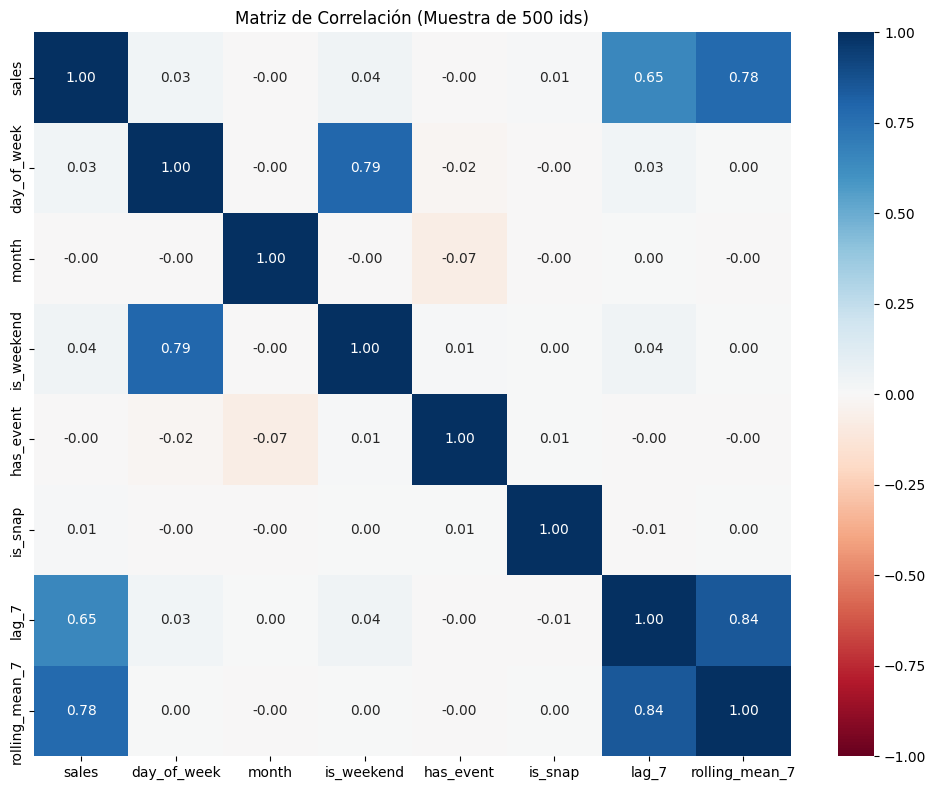

In [9]:
### MAtriz de correlación ###
d_cols = [c for c in sales.columns if c.startswith('d_')]
SAMPLE_N = 500  
ids = sales['id'].unique()
sample_ids = np.random.choice(ids, size=min(SAMPLE_N, len(ids)), replace=False)

rows = []
for sid in sample_ids:
    row = sales[sales['id'] == sid].iloc[0]
    vals = row[d_cols].values.astype('float32')
    tmp = pd.DataFrame({'d': d_cols, 'sales': vals})
    tmp = tmp.merge(calendar[['d','date','wm_yr_wk','event_name_1','snap_CA']], on='d', how='left')
    tmp = tmp.sort_values('date').reset_index(drop=True)
    tmp['day_of_week'] = tmp['date'].dt.weekday
    tmp['month'] = tmp['date'].dt.month
    tmp['is_weekend'] = tmp['day_of_week'].isin([5,6]).astype(int)
    tmp['has_event'] = (tmp['event_name_1'].fillna('No Event') != 'No Event').astype(int)
    tmp['is_snap'] = tmp['snap_CA'].fillna(False).astype(int)
    tmp['lag_7'] = tmp['sales'].shift(7)
    tmp['rolling_mean_7'] = tmp['sales'].rolling(window=7, min_periods=1).mean().shift(1)
    tmp['id'] = sid
    rows.append(tmp[['id','date','sales','day_of_week','month','is_weekend','has_event','is_snap','lag_7','rolling_mean_7']])

combined = pd.concat(rows, ignore_index=True)
combined_clean = combined.dropna()

corr_cols = ['sales','day_of_week','month','is_weekend','has_event','is_snap','lag_7','rolling_mean_7']
corr_sample = combined_clean[corr_cols].corr()

# plot
plt.figure(figsize=(10,8))
mask = np.zeros_like(corr_sample, dtype=bool)
mask[np.triu_indices_from(mask)] = False
sns.heatmap(corr_sample, mask=mask, annot=True, fmt=".2f", cmap='RdBu', vmin=-1, vmax=1)
plt.title(f'Matriz de Correlación (Muestra de {len(sample_ids)} ids)')
plt.tight_layout()
plt.show()

Cargando conjuntos de datos...
Dimensiones originales:
- Sales: (30490, 1919)
- Calendar: (1969, 14)
- Prices: (6841121, 4)
- Usando últimos 191 días (10% de la serie)
- Items con ventas > 0: 1195
Datos finales: 1195 items, 260086 precios


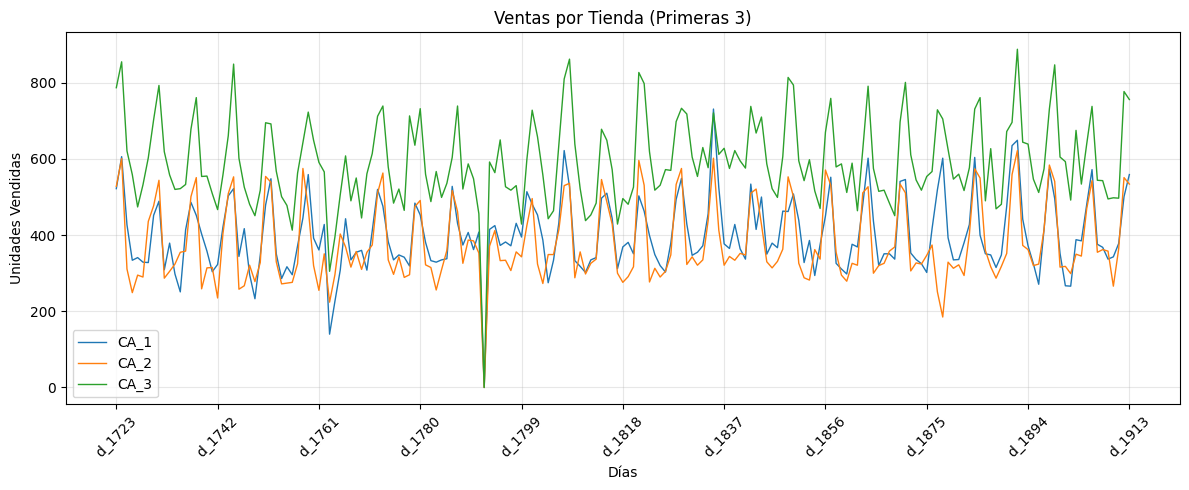

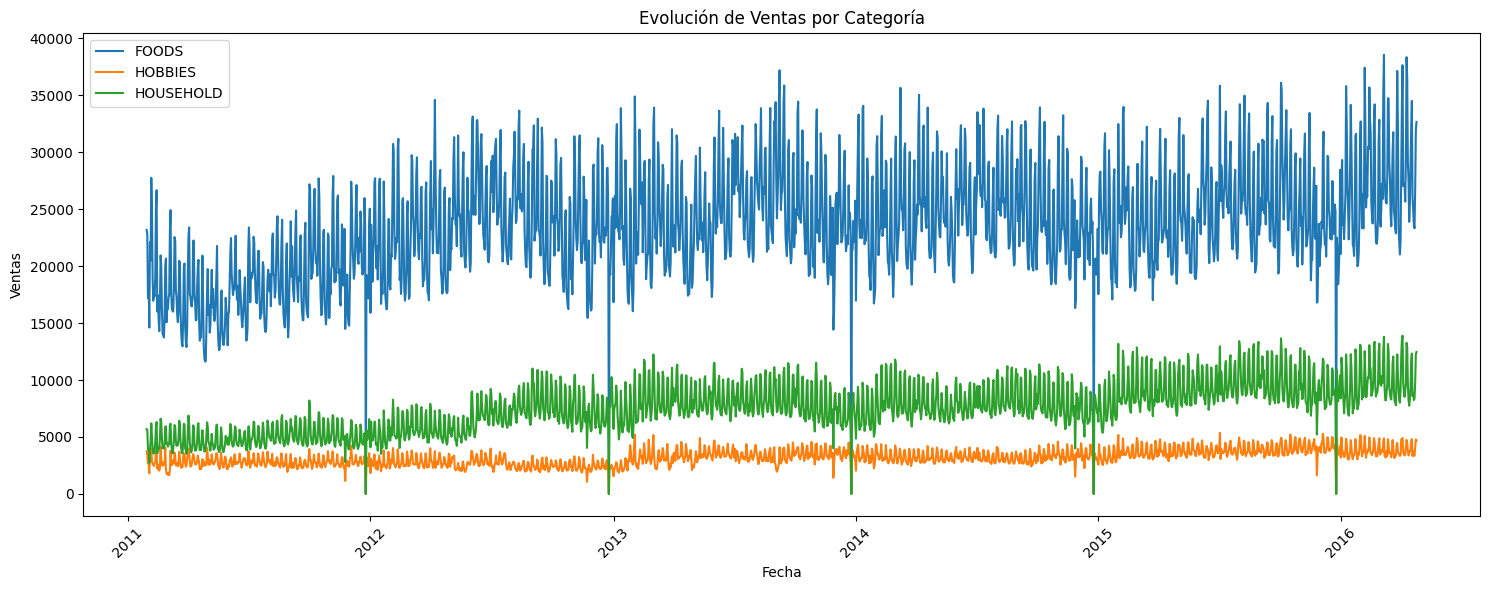

- Muestreando 76 de 191 días
Dataset optimizado: 90,820 filas
Características creadas: 90,820 filas
Características finales: 9
Columnas disponibles: ['sell_price', 'day_of_week', 'month', 'is_weekend', 'has_event', 'is_snap', 'lag_7', 'lag_28', 'rolling_mean_7']

CALIDAD DE DATOS:
- Filas totales: 90,820
- Missing values en sales: 0
- Ceros en ventas: 52125

PATRÓN SEMANAL:
  Lun: 1.30 unidades
  Mar: 1.18 unidades
  Mié: 1.15 unidades
  Jue: 1.19 unidades
  Vie: 1.12 unidades
  Sáb: 1.60 unidades
  Dom: 1.73 unidades

EFECTO DE EVENTOS:
  Días con evento: 1.01 unidades
  Días sin evento: 1.35 unidades
  Impacto: -25.3%

DISTRIBUCIÓN DE VENTAS:
  Top 10% items: 48.1% de ventas totales

ESTADÍSTICAS DESCRIPTIVAS:
  Media: 1.34
  Mediana: 0.00
  Std: 3.60
  Máximo: 131.00
  Mínimo: 0.00
Creando 3 splits optimizados...
  Split 1: Train 50,190 | Test 17,925 | 2016-01-31 to 2016-02-27
  Split 2: Train 68,115 | Test 8,365 | 2016-02-28 to 2016-03-26
  Split 3: Train 76,480 | Test 14,340 | 201

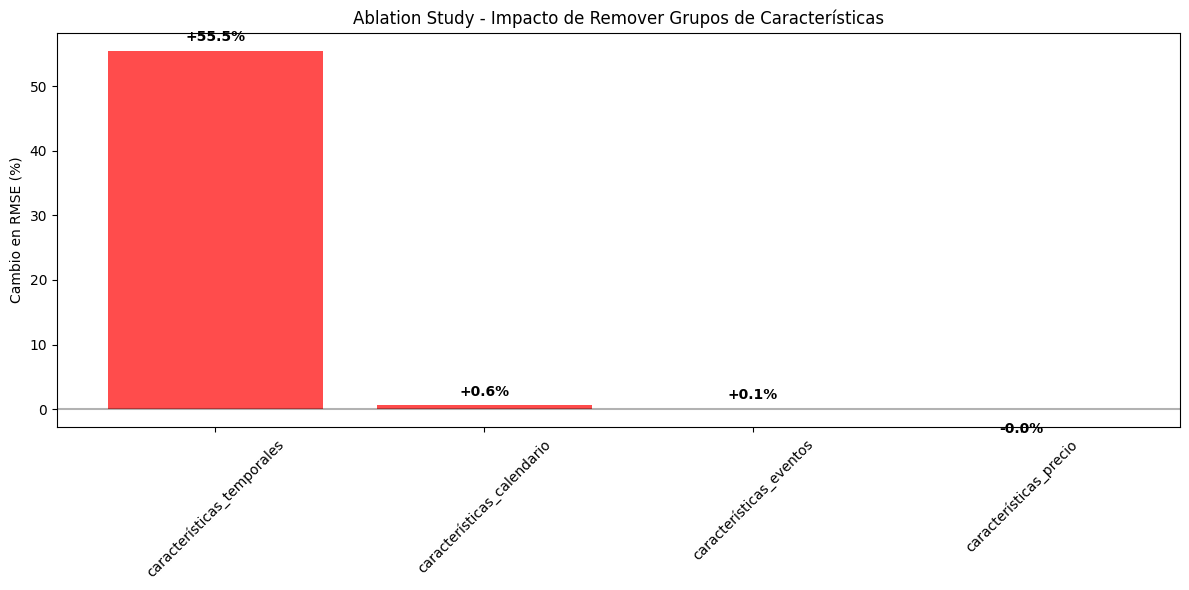

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Tienda:
  Valor 0: RMSE = 2.895, MAE = 1.200, n = 3588
  Valor 1: RMSE = 2.003, MAE = 1.167, n = 3576
  Valor 2: RMSE = 2.696, MAE = 1.431, n = 3600
  Valor 3: RMSE = 1.542, MAE = 0.868, n = 3576

Día de la semana:
  Valor 0: RMSE = 1.928, MAE = 1.032, n = 2390
  Valor 1: RMSE = 2.206, MAE = 1.062, n = 2390
  Valor 2: RMSE = 1.680, MAE = 0.942, n = 1195
  Valor 3: RMSE = 1.632, MAE = 0.943, n = 1195
  Valor 4: RMSE = 2.431, MAE = 1.084, n = 1195
  Valor 5: RMSE = 2.112, MAE = 1.279, n = 3585
  Valor 6: RMSE = 3.480, MAE = 1.505, n = 2390

Fin de semana:
  Valor 0: RMSE = 2.020, MAE = 1.022, n = 8365
  Valor 1: RMSE = 2.742, MAE = 1.370, n = 5975

Días con evento:
  Valor 0: RMSE = 2.348, MAE = 1.167, n = 14340

Días SNAP:
  Valor 0: RMSE = 1.912, MAE = 1.073, n = 7170
  Valor 1: RMSE = 2.715, MAE = 1.261, n = 7170
Realizando análisis de interpretabilidad para: Ridge

INICIANDO ANÁLISIS SHAP (muestra de 1000 instancias)


100%|██████████| 1000/1000 [00:45<00:00, 22.17it/s]


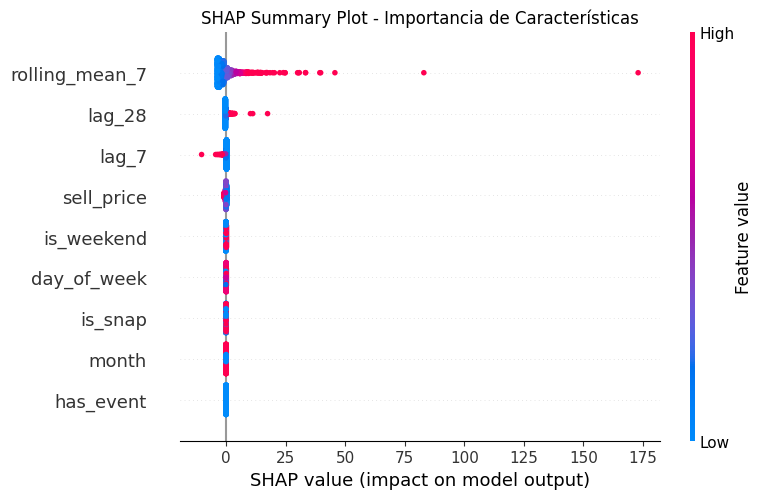

<Figure size 1000x600 with 0 Axes>

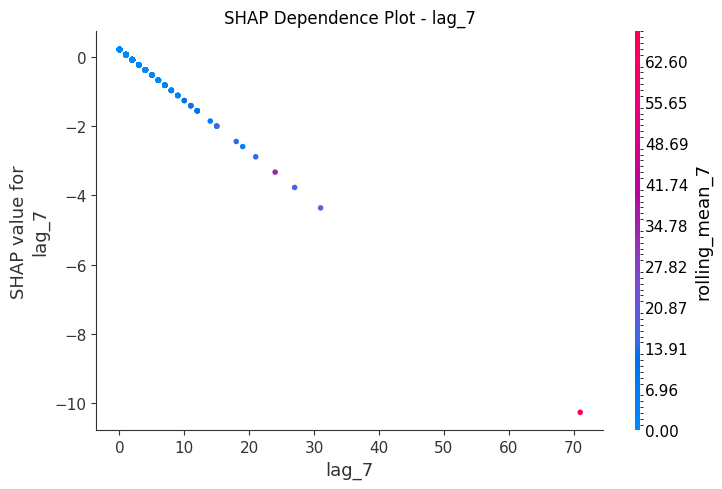

<Figure size 1000x600 with 0 Axes>

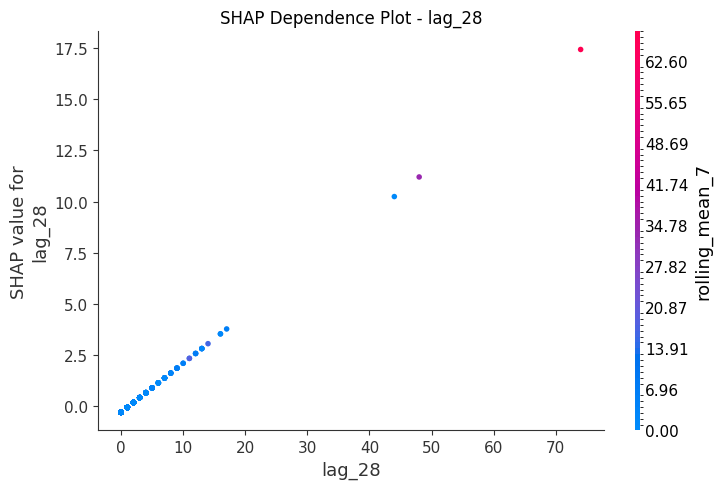

<Figure size 1000x600 with 0 Axes>

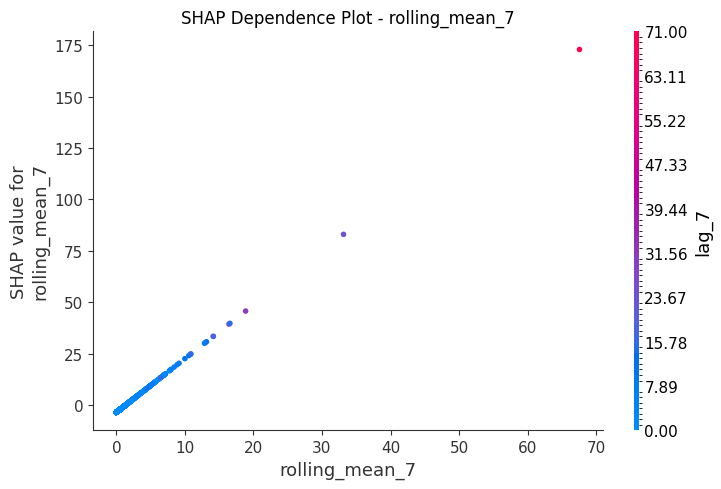

No hay características numéricas suficientes para Partial Dependence Analysis


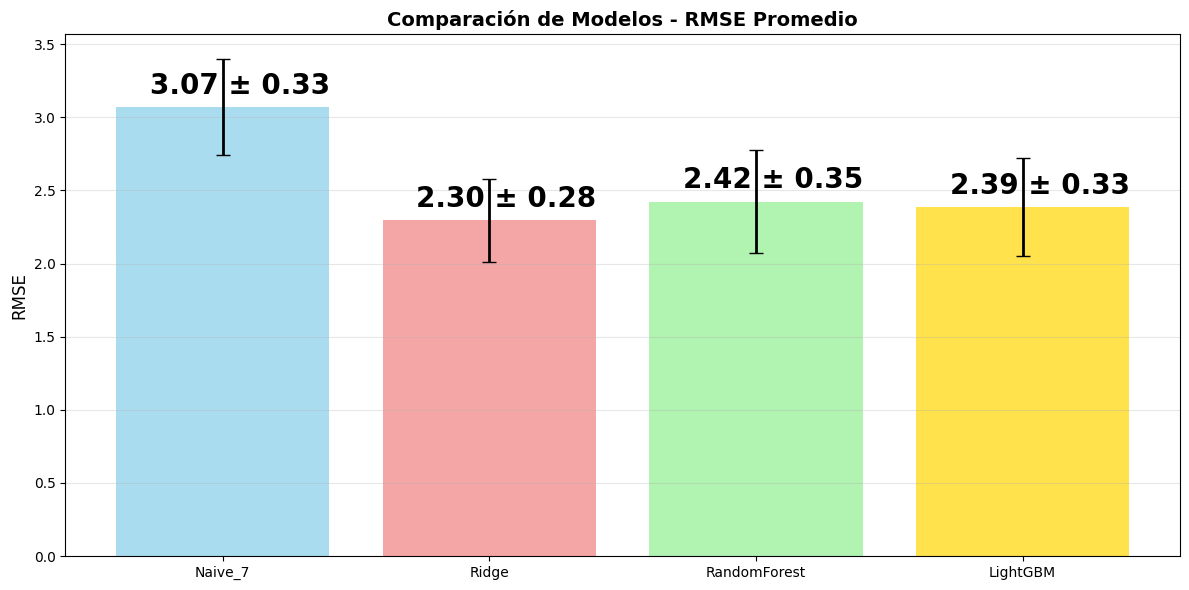

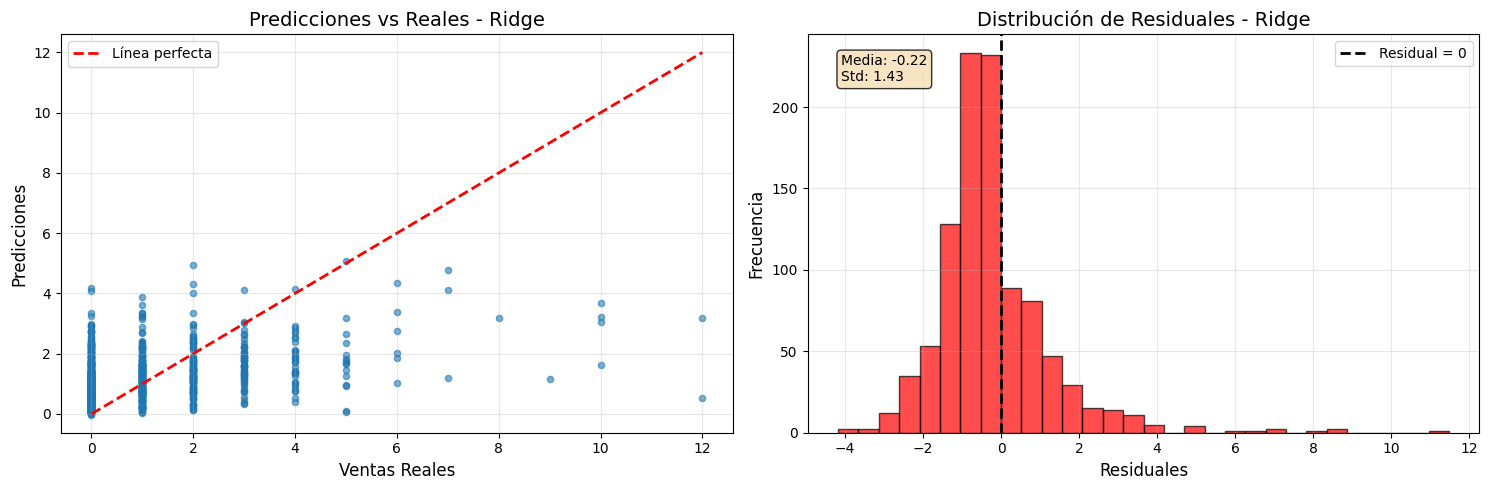

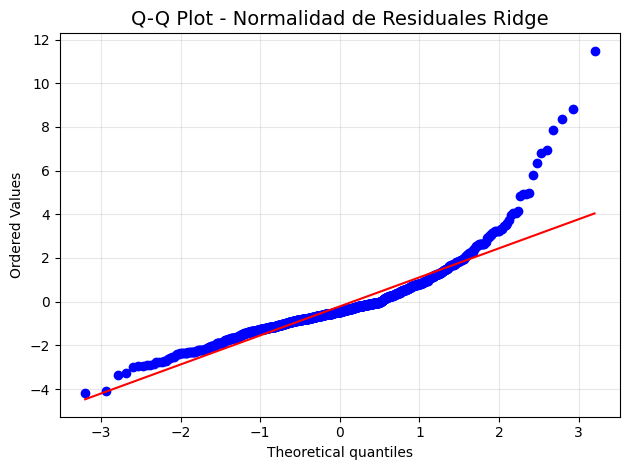

USO DE MEMORIA:
- Dataset: 13.4 MB
- Filas totales: 90,820
- Columnas totales: 17
- Modelos evaluados: 4
- Splits completados: 3

CALIDAD DE DATOS:
   - sell_price: 18 NaN (0.0%)
   - lag_7: 8365 NaN (9.2%)
   - lag_28: 33460 NaN (36.8%)
   - rolling_mean_7: 1195 NaN (1.3%)

INFORMACIÓN DE VALIDACIÓN:
   Split 1: Train=50,190, Test=17,925, Periodo=2016-01-31 to 2016-02-27
   Split 2: Train=68,115, Test=8,365, Periodo=2016-02-28 to 2016-03-26
   Split 3: Train=76,480, Test=14,340, Periodo=2016-03-27 to 2016-04-23

RESUMEN EJECUTIVO:
--------------------------------------------------
- Mejor modelo: Ridge
- RMSE promedio: 2.30
- RMSSE promedio: 0.56
- Mejora vs Naive: 25.2%
- Tamaño dataset: 90,820 filas
- Características usadas: 9
- Validación temporal: 3 splits
Impacto de características por grupo:
  - características_temporales: AUMENTA el error en 55.5%
  - características_calendario: AUMENTA el error en 0.6%
  - características_eventos: AUMENTA el error en 0.1%
  - características_p

In [10]:
### Análisis exploratorio ###

print("Cargando conjuntos de datos...")
try:
    sales_big = pd.read_csv('sales_train_validation.csv')
    calendar = pd.read_csv('calendar.csv')
    prices_big = pd.read_csv('sell_prices.csv')
    
    print(f"Dimensiones originales:")
    print(f"- Sales: {sales_big.shape}")
    print(f"- Calendar: {calendar.shape}")
    print(f"- Prices: {prices_big.shape}")
except FileNotFoundError as e:
    print(f"Error: No se encontraron los archivos: {e}")
    raise

# Aplicamos estrategia de muestreo
n = len([c for c in sales_big.columns if c.startswith("d_")])
k = int(n * 0.10)
last_cols = [f"d_{i}" for i in range(n - k + 1, n + 1)]
print(f"- Usando últimos {len(last_cols)} días (10% de la serie)")

sales_big_cal = sales_big[sales_big["state_id"] == "CA"]

np.random.seed(42)
sample_items = np.random.choice(sales_big_cal["item_id"].unique(), 
                               size=min(300, len(sales_big_cal)), 
                               replace=False)
sales_big_cal = sales_big_cal[sales_big_cal["item_id"].isin(sample_items)]

mask = sales_big_cal[last_cols].sum(axis=1) > 0
sales = sales_big_cal.loc[mask, ["item_id", "store_id"] + last_cols]
print(f"- Items con ventas > 0: {len(sales)}")

store_names = sales["store_id"].copy()
item_names = sales["item_id"].copy()
valid = sales[["item_id", "store_id"]].drop_duplicates()
prices = prices_big.merge(valid, on=["item_id", "store_id"], how="inner")

for df in [sales, prices]:
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')

store_id_mapping = dict(enumerate(sales["store_id"].cat.categories))
item_id_mapping = dict(enumerate(sales["item_id"].cat.categories))

sales["store_id"] = sales["store_id"].cat.codes
sales["item_id"] = sales["item_id"].cat.codes
prices["store_id"] = prices["store_id"].cat.codes
prices["item_id"] = prices["item_id"].cat.codes

del sales_big, sales_big_cal, prices_big
gc.collect()
print(f"Datos finales: {len(sales)} items, {len(prices)} precios")


# Comenzamos análisis exploratorio
day_cols = [col for col in sales.columns if col.startswith('d_')]

try:
    sales_by_store = sales.groupby("store_id")[day_cols].sum().T

    plt.figure(figsize=(12, 5))
    for store in sales_by_store.columns[:3]:
        store_real_name = store_id_mapping.get(store, f"Tienda {store}")
        plt.plot(sales_by_store.index, sales_by_store[store], 
                label=store_real_name, linewidth=1)

    n_ticks = 10  
    step = max(1, len(sales_by_store.index) // n_ticks)
    plt.xticks(range(0, len(sales_by_store.index), step), 
               [sales_by_store.index[i] for i in range(0, len(sales_by_store.index), step)],
               rotation=45)
    
    plt.xlabel("Días")
    plt.ylabel("Unidades Vendidas")
    plt.title("Ventas por Tienda (Primeras 3)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error en visualización: {e}")

category_sales = sales_calendar.groupby(['date', 'cat_id'])['sales'].sum().reset_index()
category_sales['date'] = pd.to_datetime(category_sales['date'])

plt.figure(figsize=(15, 6))
for category in category_sales['cat_id'].unique():
    cat_data = category_sales[category_sales['cat_id'] == category]
    plt.plot(cat_data['date'], cat_data['sales'], label=category)
plt.title('Evolución de Ventas por Categoría')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


def comprehensive_eda(df_features):
    
    print("\nCALIDAD DE DATOS:")
    print(f"- Filas totales: {len(df_features):,}")
    print(f"- Missing values en sales: {df_features['sales'].isna().sum()}")
    print(f"- Ceros en ventas: {(df_features['sales'] == 0).sum()}")
    
    if 'day_of_week' in df_features.columns:
        sales_by_dow = df_features.groupby('day_of_week')['sales'].mean()
        print(f"\nPATRÓN SEMANAL:")
        days = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
        for dow, avg_sales in sales_by_dow.items():
            day_name = days[int(dow)] if dow < len(days) else f'Día {dow}'
            print(f"  {day_name}: {avg_sales:.2f} unidades")
    
    if 'has_event' in df_features.columns:
        event_sales = df_features.groupby('has_event')['sales'].mean()
        print(f"\nEFECTO DE EVENTOS:")
        print(f"  Días con evento: {event_sales.get(1, 0):.2f} unidades")
        print(f"  Días sin evento: {event_sales.get(0, 0):.2f} unidades")
        if 0 in event_sales.index and 1 in event_sales.index:
            impact = ((event_sales[1] - event_sales[0]) / event_sales[0] * 100)
            print(f"  Impacto: {impact:+.1f}%")
    
    print(f"\nDISTRIBUCIÓN DE VENTAS:")
    if 'item_id' in df_features.columns and 'store_id' in df_features.columns:
        item_sales = df_features.groupby(['item_id', 'store_id'])['sales'].sum()
        if len(item_sales) > 0:
            top_10_cutoff = item_sales.quantile(0.9)
            top_10_sales = item_sales[item_sales >= top_10_cutoff].sum()
            total_sales = item_sales.sum()
            if total_sales > 0:
                print(f"  Top 10% items: {top_10_sales/total_sales*100:.1f}% de ventas totales")
    
    print(f"\nESTADÍSTICAS DESCRIPTIVAS:")
    print(f"  Media: {df_features['sales'].mean():.2f}")
    print(f"  Mediana: {df_features['sales'].median():.2f}")
    print(f"  Std: {df_features['sales'].std():.2f}")
    print(f"  Máximo: {df_features['sales'].max():.2f}")
    print(f"  Mínimo: {df_features['sales'].min():.2f}")

def rmsse(y_true, y_pred, y_train):
    if len(y_train) <= 28:
        return np.inf
    numerator = np.mean((y_true - y_pred) ** 2)
    denominator = np.mean((y_train[28:] - y_train[:-28]) ** 2)
    if denominator == 0:
        return np.inf
    return np.sqrt(numerator / denominator)

# Buscamos las características más importantes del modelo
def analyze_feature_importance(model, feature_names, X_test, y_test):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feat_imp.head(10), x='importance', y='feature')
        plt.title(f'Top 10 Feature Importances - {model.__class__.__name__}')
        plt.tight_layout()
        plt.show()
        
        print("\nTOP 5 CARACTERÍSTICAS MÁS IMPORTANTES:")
        for i, row in feat_imp.head().iterrows():
            print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
    else:
        print("Este modelo no entrega importancias de características")

def create_sklearn_pipeline(model, numeric_features, categorical_features=[]):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    return pipeline

# Estudio para quitar grupos de características
def ablation_study(df, train_idx, test_idx, model, feature_cols, feature_groups):
    
    train_data = df.loc[train_idx].dropna(subset=feature_cols)
    test_data = df.loc[test_idx].dropna(subset=feature_cols)
    
    X_train_baseline = train_data[feature_cols]
    y_train = train_data['sales']
    X_test_baseline = test_data[feature_cols]
    y_test = test_data['sales']
    
    pipeline = create_sklearn_pipeline(model, feature_cols)
    pipeline.fit(X_train_baseline, y_train)
    baseline_pred = pipeline.predict(X_test_baseline)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
    
    print(f"BASELINE (todas las features): RMSE = {baseline_rmse:.4f}")
    
    ablation_results = {}
    
    for group_name, features_to_remove in feature_groups.items():
        remaining_features = [f for f in feature_cols if f not in features_to_remove]
        
        if len(remaining_features) == 0:
            continue
            
        X_train_ablated = train_data[remaining_features]
        X_test_ablated = test_data[remaining_features]
        
        pipeline_ablated = create_sklearn_pipeline(model, remaining_features)
        pipeline_ablated.fit(X_train_ablated, y_train)
        ablated_pred = pipeline_ablated.predict(X_test_ablated)
        ablated_rmse = np.sqrt(mean_squared_error(y_test, ablated_pred))
        
        impact = ablated_rmse - baseline_rmse
        percent_change = (impact / baseline_rmse) * 100
        
        ablation_results[group_name] = {
            'rmse': ablated_rmse,
            'impact': impact,
            'percent_change': percent_change,
            'features_removed': len(features_to_remove),
            'features_remaining': len(remaining_features)
        }
        
        print(f"Sin {group_name}: RMSE = {ablated_rmse:.4f} "
              f"(Diferencia = {impact:+.4f}, {percent_change:+.1f}%)")
    
    return ablation_results, baseline_rmse

def error_analysis_by_subgroups(df, predictions, true_values, split_info, feature_cols):    
    test_idx = split_info['test_idx']
    test_data = df.loc[test_idx].copy()
    
    if len(predictions) == len(test_data):
        test_data['pred'] = predictions
        test_data['error'] = test_data['sales'] - test_data['pred']
        test_data['abs_error'] = np.abs(test_data['error'])
    else:
        print("Las predicciones no coinciden con los datos de test")
        return {}
    
    subgroups = {
        'store_id': 'Tienda',
        'day_of_week': 'Día de la semana', 
        'is_weekend': 'Fin de semana',
        'has_event': 'Días con evento',
        'is_snap': 'Días SNAP'
    }
    
    results = {}
    
    for subgroup_col, subgroup_name in subgroups.items():
        if subgroup_col not in test_data.columns:
            continue
            
        subgroup_errors = {}
        
        for value in sorted(test_data[subgroup_col].unique()):
            mask = test_data[subgroup_col] == value
            
            if mask.sum() > 0:
                subgroup_rmse = np.sqrt(mean_squared_error(
                    test_data.loc[mask, 'sales'], 
                    test_data.loc[mask, 'pred']
                ))
                subgroup_mae = mean_absolute_error(
                    test_data.loc[mask, 'sales'], 
                    test_data.loc[mask, 'pred']
                )
                
                subgroup_errors[value] = {
                    'rmse': subgroup_rmse,
                    'mae': subgroup_mae,
                    'count': mask.sum(),
                    'mean_sales': test_data.loc[mask, 'sales'].mean(),
                    'mean_pred': test_data.loc[mask, 'pred'].mean()
                }
        
        if subgroup_errors:
            results[subgroup_col] = subgroup_errors
            
            print(f"\n{subgroup_name}:")
            for value, metrics in subgroup_errors.items():
                value_name = f"Valor {value}" if not isinstance(value, (bool, np.bool_)) else ("Sí" if value else "No")
                print(f"  {value_name}: RMSE = {metrics['rmse']:.3f}, "
                      f"MAE = {metrics['mae']:.3f}, "
                      f"n = {metrics['count']}")
    
    return results

def shap_analysis(model, X_test, feature_names, max_samples=1000):
    try:
        
        print(f"\nINICIANDO ANÁLISIS SHAP (muestra de {min(max_samples, len(X_test))} instancias)")
        
        if len(X_test) > max_samples:
            sample_idx = np.random.choice(len(X_test), size=max_samples, replace=False)
            X_sample = X_test.iloc[sample_idx] if hasattr(X_test, 'iloc') else X_test[sample_idx]
        else:
            X_sample = X_test
        
        if hasattr(model, 'predict_proba'):
            explainer = shap.TreeExplainer(model)
        else:
            def model_predict(x):
                return model.predict(x)
            explainer = shap.KernelExplainer(model_predict, X_sample)
        
        shap_values = explainer.shap_values(X_sample)
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
        plt.title("SHAP Summary Plot - Importancia de Características")
        plt.tight_layout()
        plt.show()
        
        if hasattr(shap_values, 'shape') and len(shap_values.shape) > 1:
            shap_importance = np.mean(np.abs(shap_values), axis=0)
            top_features_idx = np.argsort(shap_importance)[-3:]
            
            for i, feature_idx in enumerate(top_features_idx):
                if feature_idx < len(feature_names):
                    feature_name = feature_names[feature_idx]
                    plt.figure(figsize=(10, 6))
                    shap.dependence_plot(feature_idx, shap_values, X_sample, 
                                       feature_names=feature_names, show=False)
                    plt.title(f"SHAP Dependence Plot - {feature_name}")
                    plt.tight_layout()
                    plt.show()
    except Exception as e:
        print(f"Error en análisis SHAP: {e}")

def partial_dependence_analysis(model, X_train, feature_names, top_features=3):
    try:
        numeric_features = []
        for feature in feature_names:
            if (X_train[feature].dtype in [np.int64, np.float64] and 
                X_train[feature].nunique() > 5):
                numeric_features.append(feature)
        
        if hasattr(model, 'feature_importances_'):
            feature_imp = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            top_numeric_features = [f for f in feature_imp['feature'] if f in numeric_features][:top_features]
        else:
            top_numeric_features = numeric_features[:top_features]
        
        if top_numeric_features:
            fig, ax = plt.subplots(figsize=(12, 8))
            PartialDependenceDisplay.from_estimator(
                model, X_train, top_numeric_features,
                ax=ax, grid_resolution=20
            )
            plt.title("Partial Dependence Plots")
            plt.tight_layout()
            plt.show()
            
            print(f"Partial Dependence Analysis completado para: {', '.join(top_numeric_features)}")
        else:
            print("No hay características numéricas suficientes para Partial Dependence Analysis")
    except Exception as e:
        print(f"Error en Partial Dependence Analysis: {e}")

# Preprocesamiento
def prepare_data_optimized(sales_df, calendar_df, price_df, sample_fraction=0.3):
    day_cols = [col for col in sales_df.columns if col.startswith('d_')]
    if sample_fraction < 1.0:
        sample_size = int(len(day_cols) * sample_fraction)
        day_cols_sampled = np.random.choice(day_cols, size=sample_size, replace=False)
        print(f"- Muestreando {sample_size} de {len(day_cols)} días")
    else:
        day_cols_sampled = day_cols
    
    df_long = sales_df.melt(
        id_vars=['item_id', 'store_id'],
        value_vars=day_cols_sampled,
        var_name='d',
        value_name='sales'
    )
    
    calendar_subset = calendar_df[['d', 'date', 'wm_yr_wk', 'event_name_1', 'snap_CA']].copy()
    df_long = df_long.merge(calendar_subset, on='d', how='left')
    df_long['date'] = pd.to_datetime(df_long['date'])
    
    day_to_week = dict(zip(calendar_df["d"], calendar_df["wm_yr_wk"]))
    df_long['wm_yr_wk'] = df_long['d'].map(day_to_week)
    
    price_subset = price_df[['store_id', 'item_id', 'wm_yr_wk', 'sell_price']].copy()
    df_long = df_long.merge(price_subset, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    
    df_long = df_long.sort_values(['item_id', 'store_id', 'date']).reset_index(drop=True)
    
    print(f"Dataset optimizado: {len(df_long):,} filas")
    return df_long

def create_features_optimized(df):
    df = df.copy()    
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(np.int8)
    df['has_event'] = (~df['event_name_1'].isna()).astype(np.int8)
    df['is_snap'] = (df['snap_CA'] == 1).astype(np.int8)
    
    df['lag_7'] = df.groupby(['item_id', 'store_id'])['sales'].shift(7)
    df['lag_28'] = df.groupby(['item_id', 'store_id'])['sales'].shift(28)
    
    df['rolling_mean_7'] = df.groupby(['item_id', 'store_id'])['sales'].transform(
        lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
    )
    
    for col in ['sales', 'sell_price', 'lag_7', 'lag_28', 'rolling_mean_7']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(np.float32)
    
    print(f"Características creadas: {len(df):,} filas")
    return df

try:
    df_processed = prepare_data_optimized(sales, calendar, prices, sample_fraction=0.4)
    df_features = create_features_optimized(df_processed)
    
    FEATURE_COLS = [
        'sell_price', 'day_of_week', 'month', 'is_weekend', 
        'has_event', 'is_snap', 'lag_7', 'lag_28', 'rolling_mean_7'
    ]
    
    FEATURE_COLS = [col for col in FEATURE_COLS if col in df_features.columns]
    print(f"Características finales: {len(FEATURE_COLS)}")
    print(f"Columnas disponibles: {FEATURE_COLS}")
    
    comprehensive_eda(df_features)
    
except Exception as e:
    print(f"Error en preprocesamiento: {e}")
    raise

def create_optimized_splits(df, n_splits=3, test_days=28):
    """Crear splits optimizados que no consuman mucha memoria"""
    print(f"Creando {n_splits} splits optimizados...")
    
    unique_dates = sorted(df['date'].unique())
    max_date = unique_dates[-1]
    
    splits = []
    
    for i in range(n_splits, 0, -1):
        test_end = max_date - pd.Timedelta(days=(i-1) * test_days)
        test_start = test_end - pd.Timedelta(days=test_days - 1)
        
        train_mask = df['date'] < test_start
        test_mask = (df['date'] >= test_start) & (df['date'] <= test_end)
        
        train_idx = df[train_mask].index.tolist()
        test_idx = df[test_mask].index.tolist()
        
        splits.append({
            'split_num': n_splits - i + 1,
            'train_idx': train_idx,
            'test_idx': test_idx,
            'test_dates': (test_start, test_end)
        })
        
        train_count = len(train_idx)
        test_count = len(test_idx)
        print(f"  Split {n_splits - i + 1}: Train {train_count:,} | Test {test_count:,} | {test_start.date()} to {test_end.date()}")
    
    return splits, df

try:
    splits, df_features = create_optimized_splits(df_features, n_splits=3, test_days=28)
    print(f"Splits creados exitosamente: {len(splits)} splits")
except Exception as e:
    print(f"Error creando splits: {e}")
    raise


def evaluate_model_fast(df, train_idx, test_idx, model_name, feature_cols):
    try:
        train_data = df.loc[train_idx].dropna(subset=feature_cols)
        test_data = df.loc[test_idx].dropna(subset=feature_cols)
        
        if len(train_data) == 0 or len(test_data) == 0:
            print(f"  {model_name}: Datos insuficientes")
            return {'rmse': np.inf, 'mae': np.inf, 'rmsse': np.inf, 'model': None, 'pipeline': None}
        
        X_train = train_data[feature_cols]
        y_train = train_data['sales'].values
        X_test = test_data[feature_cols]
        y_test = test_data['sales'].values
        
        if model_name == 'Naive_7':
            predictions = test_data['lag_7'].fillna(0).values
            model = None
            pipeline = None
        else:
            if model_name == 'Ridge':
                base_model = Ridge(alpha=1.0, random_state=42)
            elif model_name == 'RandomForest':
                base_model = RandomForestRegressor(
                    n_estimators=30,
                    max_depth=8, 
                    random_state=42, 
                    n_jobs=-1
                )
            elif model_name == 'LightGBM':
                base_model = lgb.LGBMRegressor(
                    n_estimators=50,
                    max_depth=6,
                    learning_rate=0.1,
                    random_state=42,
                    n_jobs=-1,
                    verbose=-1
                )
            else:
                return {'rmse': np.inf, 'mae': np.inf, 'rmsse': np.inf, 'model': None, 'pipeline': None}
            
            pipeline = create_sklearn_pipeline(base_model, feature_cols)
            pipeline.fit(X_train, y_train)
            predictions = pipeline.predict(X_test)
            model = pipeline.named_steps['model']
        
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        rmsse_val = rmsse(y_test, predictions, y_train)
        
        return {
            'rmse': rmse, 
            'mae': mae, 
            'rmsse': rmsse_val,
            'model': model, 
            'pipeline': pipeline,
            'predictions': predictions,
            'X_test': X_test,
            'y_test': y_test
        }
    
    except Exception as e:
        print(f"  Error en {model_name}: {e}")
        return {'rmse': np.inf, 'mae': np.inf, 'rmsse': np.inf, 'model': None, 'pipeline': None}

def run_fast_backtesting(splits, df, model_names):

    results = {model: [] for model in model_names}
    
    for split_info in splits:
        split_num = split_info['split_num']
        train_idx = split_info['train_idx']
        test_idx = split_info['test_idx']
        
        print(f"\nSplit {split_num}:")
        
        for model_name in model_names:
            result = evaluate_model_fast(df, train_idx, test_idx, model_name, FEATURE_COLS)
            result['split_num'] = split_num
            result['split_info'] = split_info
            results[model_name].append(result)
            
            if np.isfinite(result['rmse']):
                rmsse_str = f"{result['rmsse']:>7.2f}" if np.isfinite(result['rmsse']) else "   N/A"
                print(f"  {model_name:<15} RMSE: {result['rmse']:>7.2f}  MAE: {result['mae']:>7.2f}  RMSSE: {rmsse_str}")
            else:
                print(f"  {model_name:<15} RMSE: {'FAILED':>7}  MAE: {'FAILED':>7}  RMSSE: {'FAILED':>7}")
    
    return results

MODEL_NAMES = ['Naive_7', 'Ridge', 'RandomForest', 'LightGBM']

try:
    results = run_fast_backtesting(splits, df_features, MODEL_NAMES)
    print("Backtesting completado")
except Exception as e:
    print(f"Error en backtesting: {e}")
    raise

# Evaluación y resultados
def generate_fast_summary(results):
    """Generar resumen rápido de resultados con RMSSE"""
    summary = {}
    
    for model_name, model_results in results.items():
        if not model_results:
            continue
            
        rmses = [r['rmse'] for r in model_results if np.isfinite(r['rmse'])]
        maes = [r['mae'] for r in model_results if np.isfinite(r['mae'])]
        rmsses = [r['rmsse'] for r in model_results if np.isfinite(r['rmsse'])]
        
        if rmses:
            summary[model_name] = {
                'rmse_mean': np.mean(rmses),
                'rmse_std': np.std(rmses),
                'mae_mean': np.mean(maes),
                'mae_std': np.std(maes),
                'rmsse_mean': np.mean(rmsses) if rmsses else np.inf,
                'rmsse_std': np.std(rmsses) if rmsses else np.inf,
                'n_splits': len(rmses)
            }
    
    return summary

summary = generate_fast_summary(results)

if summary:
    print("\nRESULTADOS (Media ± Desviación Estándar)")
    print("=" * 65)
    print(f"{'Modelo':<15} {'RMSE':>10} {'MAE':>10} {'RMSSE':>10} {'Splits':>8}")
    print("-" * 65)

    for model_name, metrics in summary.items():
        rmse_str = f"{metrics['rmse_mean']:.2f} ± {metrics['rmse_std']:.2f}"
        mae_str = f"{metrics['mae_mean']:.2f} ± {metrics['mae_std']:.2f}"
        
        if np.isfinite(metrics['rmsse_mean']):
            rmsse_str = f"{metrics['rmsse_mean']:.2f} ± {metrics['rmsse_std']:.2f}"
        else:
            rmsse_str = "N/A"
            
        print(f"{model_name:<15} {rmse_str:>10} {mae_str:>10} {rmsse_str:>10} {metrics['n_splits']:>8}")

    print("=" * 65)

    best_model_name, best_model_metrics = min(summary.items(), key=lambda x: x[1]['rmse_mean'])
    print(f"\nMEJOR MODELO (por RMSE): {best_model_name}")
    print(f"   - RMSE: {best_model_metrics['rmse_mean']:.2f} (±{best_model_metrics['rmse_std']:.2f})")
    print(f"   - MAE: {best_model_metrics['mae_mean']:.2f} (±{best_model_metrics['mae_std']:.2f})")
    
    if np.isfinite(best_model_metrics['rmsse_mean']):
        print(f"   - RMSSE: {best_model_metrics['rmsse_mean']:.2f} (±{best_model_metrics['rmsse_std']:.2f})")
    
    if 'Naive_7' in summary:
        improvement = ((summary['Naive_7']['rmse_mean'] - best_model_metrics['rmse_mean']) / 
                      summary['Naive_7']['rmse_mean'] * 100)
        print(f"   - Mejora vs Naive: {improvement:.1f}%")
else:
    print("No se pudieron calcular los resultados")


if summary and best_model_name != 'Naive_7':
    try:
        feature_groups = {
            'características_temporales': ['lag_7', 'lag_28', 'rolling_mean_7'],
            'características_calendario': ['day_of_week', 'month', 'is_weekend'],
            'características_eventos': ['has_event', 'is_snap'],
            'características_precio': ['sell_price']
        }
        
        last_split = splits[-1]
        train_idx = last_split['train_idx']
        test_idx = last_split['test_idx']
        
        best_model_instance = None
        for result in results[best_model_name]:
            if result['model'] is not None:
                best_model_instance = result['model']
                break
        
        if best_model_instance is not None:
            ablation_results, baseline_rmse = ablation_study(
                df_features, train_idx, test_idx, 
                best_model_instance, FEATURE_COLS, feature_groups
            )
            
            if ablation_results:
                plt.figure(figsize=(12, 6))
                groups = list(ablation_results.keys())
                impacts = [ablation_results[g]['percent_change'] for g in groups]
                
                colors = ['red' if impact > 0 else 'green' for impact in impacts]
                bars = plt.bar(groups, impacts, color=colors, alpha=0.7)
                
                plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
                plt.ylabel('Cambio en RMSE (%)')
                plt.title('Ablation Study - Impacto de Remover Grupos de Características')
                plt.xticks(rotation=45)
                
                for bar, impact in zip(bars, impacts):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (1 if impact > 0 else -2),
                            f'{impact:+.1f}%', ha='center', va='bottom' if impact > 0 else 'top', 
                            fontweight='bold')
                
                plt.tight_layout()
                plt.show()
        
    except Exception as e:
        print(f"Error en ablation study: {e}")

if summary and best_model_name in results:
    try:
        last_result = results[best_model_name][-1]
        last_split = splits[-1]
        
        if 'predictions' in last_result and last_result['predictions'] is not None:
            error_analysis = error_analysis_by_subgroups(
                df_features, 
                last_result['predictions'], 
                last_result['y_test'],
                last_split,
                FEATURE_COLS
            )
    except Exception as e:
        print(f"Error en análisis de errores por subgrupos: {e}")


if summary and best_model_name in results and best_model_name != 'Naive_7':
    try:
        print(f"Realizando análisis de interpretabilidad para: {best_model_name}")
        
        best_result = results[best_model_name][-1]
        
        if best_result['model'] is not None and 'X_test' in best_result:
            shap_analysis(best_result['model'], best_result['X_test'], FEATURE_COLS)
            
            train_idx = splits[-1]['train_idx']
            train_data = df_features.loc[train_idx].dropna(subset=FEATURE_COLS)
            X_train = train_data[FEATURE_COLS]
            
            partial_dependence_analysis(best_result['model'], X_train, FEATURE_COLS)
        else:
            print("No se pudo realizar análisis (modelo o datos no disponibles)")
            
    except Exception as e:
        print(f"Error en análisis: {e}")


try:
    if summary:
        plt.figure(figsize=(12, 6))
        
        models = list(summary.keys())
        rmse_means = [summary[model]['rmse_mean'] for model in models]
        rmse_stds = [summary[model]['rmse_std'] for model in models]
        
        bars = plt.bar(models, rmse_means, yerr=rmse_stds, 
                      alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'],
                      capsize=5, error_kw={'linewidth': 2})
        
        plt.title('Comparación de Modelos - RMSE Promedio', fontsize=14, fontweight='bold')
        plt.ylabel('RMSE', fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        
        for bar, value, std in zip(bars, rmse_means, rmse_stds):
            # Posicionar el texto ligeramente a la derecha para mejor legibilidad
            text_x = bar.get_x() + bar.get_width()/2 + 0.1
            plt.text(text_x, bar.get_height() + 0.05,
                    f'{value:.2f} ± {std:.2f}  ', 
                    ha='center', va='bottom', fontweight='bold', fontsize=20)
        
        plt.tight_layout()
        plt.show()

    if results and best_model_name in results and results[best_model_name]:
        best_result = results[best_model_name][-1]
        
        if 'predictions' in best_result and best_result['predictions'] is not None:
            test_idx = splits[-1]['test_idx']
            sample_size = min(1000, len(test_idx))
            sample_idx = np.random.choice(test_idx, size=sample_size, replace=False)
            
            test_data = df_features.loc[test_idx]
            predictions = best_result['predictions']
            
            if len(predictions) == len(test_data):
                results_df = pd.DataFrame({
                    'real': test_data['sales'].values,
                    'pred': predictions
                }).iloc[:sample_size]
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
                
                ax1.scatter(results_df['real'], results_df['pred'], alpha=0.6, s=20)
                max_val = max(results_df['real'].max(), results_df['pred'].max())
                ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Línea perfecta')
                ax1.set_xlabel('Ventas Reales', fontsize=12)
                ax1.set_ylabel('Predicciones', fontsize=12)
                ax1.set_title(f'Predicciones vs Reales - {best_model_name}', fontsize=14)
                ax1.grid(True, alpha=0.3)
                ax1.legend()
                
                residuals = results_df['real'] - results_df['pred']
                ax2.hist(residuals, bins=30, alpha=0.7, color='red', edgecolor='black')
                ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Residual = 0')
                ax2.set_xlabel('Residuales', fontsize=12)
                ax2.set_ylabel('Frecuencia', fontsize=12)
                ax2.set_title(f'Distribución de Residuales - {best_model_name}', fontsize=14)
                ax2.grid(True, alpha=0.3)
                ax2.legend()
                
                mean_residual = residuals.mean()
                std_residual = residuals.std()
                ax2.text(0.05, 0.95, f'Media: {mean_residual:.2f}\nStd: {std_residual:.2f}', 
                        transform=ax2.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
                
                plt.tight_layout()
                plt.show()

                # QQ plot para normalidad de residuales
                stats.probplot(residuals, dist="norm", plot=plt)
                plt.title(f'Q-Q Plot - Normalidad de Residuales {best_model_name}', fontsize=14)
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
except Exception as e:
    print(f"Error en visualizaciones: {e}")


# Análisis de memoria y datos
def get_memory_usage(df):
    """Calcular uso de memoria de un DataFrame"""
    memory_mb = df.memory_usage(deep=True).sum() / 1024 / 1024
    return memory_mb

try:
    memory_usage = get_memory_usage(df_features)
    print(f"USO DE MEMORIA:")
    print(f"- Dataset: {memory_usage:.1f} MB")
    print(f"- Filas totales: {len(df_features):,}")
    print(f"- Columnas totales: {len(df_features.columns)}")
    print(f"- Modelos evaluados: {len(MODEL_NAMES)}")
    print(f"- Splits completados: {len(splits)}")
    
    print(f"\nCALIDAD DE DATOS:")
    nan_counts = df_features[FEATURE_COLS + ['sales']].isna().sum()
    for col, count in nan_counts.items():
        if count > 0:
            print(f"   - {col}: {count} NaN ({count/len(df_features)*100:.1f}%)")
    
    print(f"\nINFORMACIÓN DE VALIDACIÓN:")
    for i, split in enumerate(splits, 1):
        train_size = len(split['train_idx'])
        test_size = len(split['test_idx'])
        test_start, test_end = split['test_dates']
        print(f"   Split {i}: Train={train_size:,}, Test={test_size:,}, Periodo={test_start.date()} to {test_end.date()}")
    
except Exception as e:
    print(f"Error en análisis de memoria: {e}")

print("\nRESUMEN EJECUTIVO:")
print("-" * 50)
if summary:
    print(f"- Mejor modelo: {best_model_name}")
    print(f"- RMSE promedio: {best_model_metrics['rmse_mean']:.2f}")
    if np.isfinite(best_model_metrics['rmsse_mean']):
        print(f"- RMSSE promedio: {best_model_metrics['rmsse_mean']:.2f}")
    if 'Naive_7' in summary:
        improvement = ((summary['Naive_7']['rmse_mean'] - best_model_metrics['rmse_mean']) / 
                      summary['Naive_7']['rmse_mean'] * 100)
        print(f"- Mejora vs Naive: {improvement:.1f}%")
    print(f"- Tamaño dataset: {len(df_features):,} filas")
    print(f"- Características usadas: {len(FEATURE_COLS)}")
    print(f"- Validación temporal: {len(splits)} splits")


if 'ablation_results' in locals():
    print("Impacto de características por grupo:")
    for group, result in ablation_results.items():
        impact_dir = "AUMENTA" if result['percent_change'] > 0 else "reduce"
        print(f"  - {group}: {impact_dir} el error en {abs(result['percent_change']):.1f}%")

FASE 1: COMPARACIÓN CON SERIES MUESTREADAS (20 series)
Evaluando en 20 series muestreadas

Serie 1/20: Item 159, Store 2
Tipo: Intermitente (Ceros: 84.4%, CV: 2.34)
   Ridge: RMSE = 0.327


Exception in thread Thread-96 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\brian\miniconda3\envs\ipopt-env\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\brian\miniconda3\envs\ipopt-env\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\brian\miniconda3\envs\ipopt-env\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\brian\miniconda3\envs\ipopt-env\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa2 in position 116: invalid start byte


   LightGBM: RMSE = 0.309
   ETS: RMSE = 0.334
   ARIMA: RMSE = 0.286 (Orden: (0, 0, 0))
   SARIMA: RMSE = 0.286 (Orden: (0, 0, 0), Estacional: (0, 0, 0, 28))

Serie 2/20: Item 61, Store 0
Tipo: Estable (Ceros: 25.0%, CV: 0.91)
   Ridge: RMSE = 1.469
   LightGBM: RMSE = 1.660
   ETS: RMSE = 1.502
   ARIMA: RMSE = 1.463 (Orden: (0, 0, 0))
   SARIMA: RMSE = 1.463 (Orden: (0, 0, 0), Estacional: (0, 0, 0, 28))

Serie 3/20: Item 273, Store 1
Tipo: Intermitente (Ceros: 90.6%, CV: 3.13)
   Ridge: RMSE = 0.927
   LightGBM: RMSE = 0.868
   ETS: RMSE = 0.855
   ARIMA: RMSE = 0.865 (Orden: (0, 0, 0))
   SARIMA error: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.

Serie 4/20: Item 279, Store 1
Tipo: Intermitente (Ceros: 87.5%, CV: 2.84)
   Ridge: RMSE = 1.160
   LightGBM: RMSE = 1.105
   ETS: RMSE = 1.132
   ARIMA: RMSE = 1.110 (Orden: (0, 1, 1))
   SARIMA: RMSE = 1.149 (Orden: (0, 0, 0), Estacional: (1, 1, 0, 28

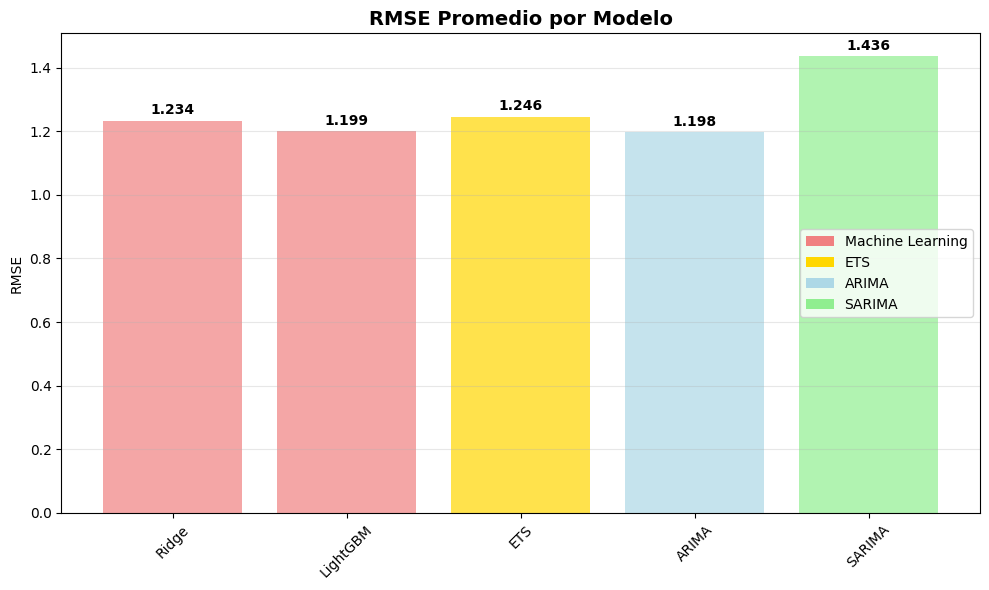

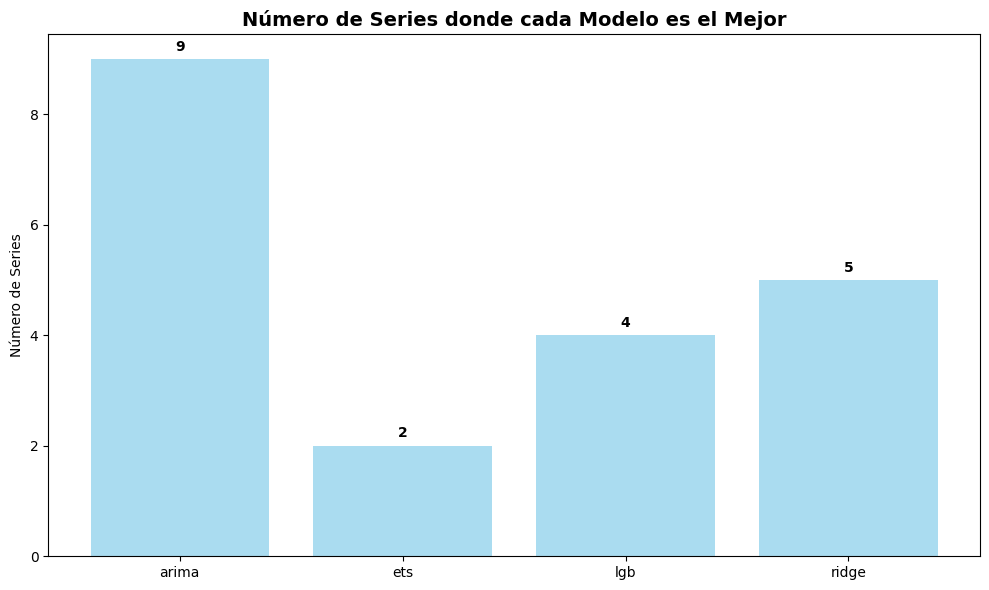

ARIMA ganó en 9 de 19 series (47.4%)
SARIMA ganó en 0 de 19 series (0.0%)

ARIMA - DISTRIBUCIÓN DE ÓRDENES EN VICTORIAS:
  (0, 0, 0): 7 victorias (77.8%)
  (0, 0, 1): 1 victorias (11.1%)
  (0, 1, 1): 1 victorias (11.1%)

ARIMA - RENDIMIENTO POR CONFIGURACIÓN:
  (0, 0, 1): RMSE = 0.552 ± 0.000 (n=1)
  (0, 0, 0): RMSE = 0.988 ± 0.559 (n=7)
  (0, 1, 1): RMSE = 4.153 ± 0.000 (n=1)

🔍 VICTORIAS POR TIPO DE SERIE:
  Intermitente - ARIMA: 4 victorias (44.4%)
  Mixta - ARIMA: 3 victorias (33.3%)
  Estable - ARIMA: 2 victorias (22.2%)
FASE 2: COMPARACIÓN CON TODAS LAS SERIES
Demasiadas series (1195), usando muestra ampliada de 50 series
Evaluando en 50 series muestreadas

Serie 1/50: Item 159, Store 2
Tipo: Intermitente (Ceros: 84.4%, CV: 2.34)
   Ridge: RMSE = 0.327
   LightGBM: RMSE = 0.309
   ETS: RMSE = 0.334
   ARIMA: RMSE = 0.286 (Orden: (0, 0, 0))
   SARIMA: RMSE = 0.286 (Orden: (0, 0, 0), Estacional: (0, 0, 0, 28))

Serie 2/50: Item 61, Store 0
Tipo: Estable (Ceros: 25.0%, CV: 0.91)
   

<Figure size 1200x600 with 0 Axes>

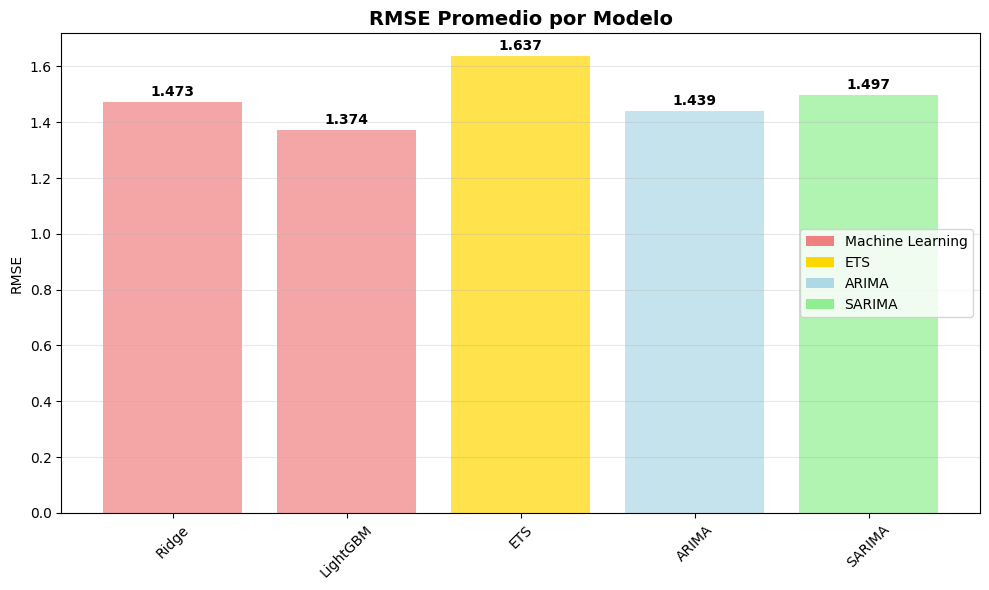

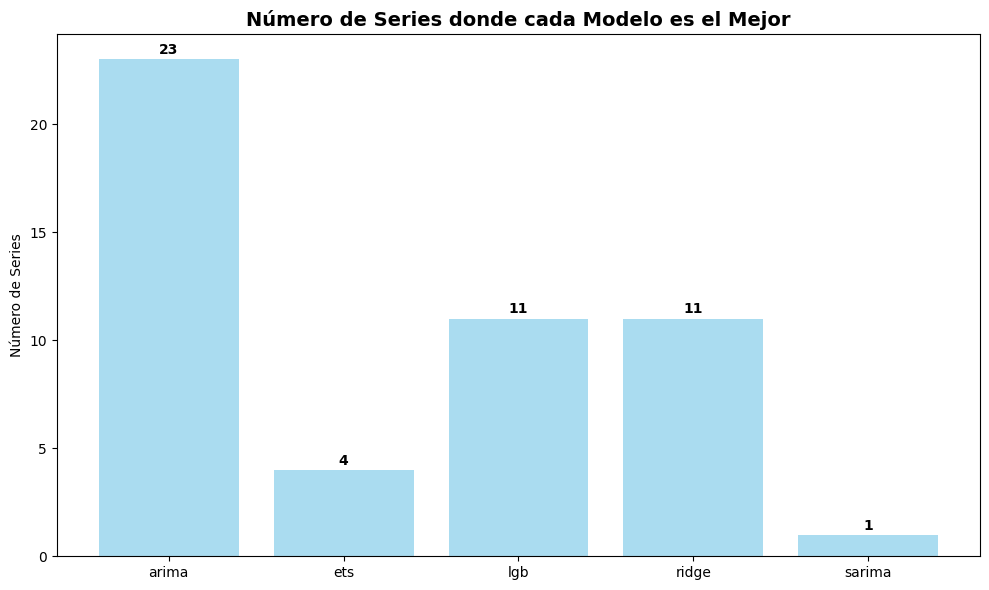

ARIMA ganó en 23 de 49 series (46.9%)
SARIMA ganó en 1 de 49 series (2.0%)

ARIMA - DISTRIBUCIÓN DE ÓRDENES EN VICTORIAS:
  (0, 0, 0): 14 victorias (60.9%)
  (0, 0, 1): 2 victorias (8.7%)
  (1, 0, 1): 2 victorias (8.7%)
  (0, 1, 1): 1 victorias (4.3%)
  (3, 1, 2): 1 victorias (4.3%)
  (1, 1, 2): 1 victorias (4.3%)
  (4, 0, 1): 1 victorias (4.3%)
  (3, 0, 2): 1 victorias (4.3%)

ARIMA - RENDIMIENTO POR CONFIGURACIÓN:
  (0, 0, 1): RMSE = 0.414 ± 0.138 (n=2)
  (0, 0, 0): RMSE = 0.893 ± 0.544 (n=14)
  (1, 0, 1): RMSE = 0.914 ± 0.016 (n=2)
  (3, 0, 2): RMSE = 1.001 ± 0.000 (n=1)
  (1, 1, 2): RMSE = 1.113 ± 0.000 (n=1)
  (3, 1, 2): RMSE = 1.559 ± 0.000 (n=1)
  (4, 0, 1): RMSE = 1.576 ± 0.000 (n=1)
  (0, 1, 1): RMSE = 4.153 ± 0.000 (n=1)

SARIMA - DISTRIBUCIÓN DE ÓRDENES EN VICTORIAS:
Órdenes no estacionales:
  (0, 0, 1): 1 victorias (100.0%)

Órdenes estacionales:
  (0, 0, 0, 28): 1 victorias (100.0%)

SARIMA - RENDIMIENTO POR CONFIGURACIÓN:
  (0, 0, 1)_(0, 0, 0, 28): RMSE = 1.295 ± 0.000 (n

<Figure size 1200x600 with 0 Axes>

In [11]:
### Comparacion con Series Temporales ###

def comprehensive_comparison_with_both_arima(df_features, splits, n_series=20, use_full_series=False):
    if use_full_series:
        unique_series = df_features[['item_id', 'store_id']].drop_duplicates()
        print(f"Usando TODAS las series disponibles: {len(unique_series)} series")
    else:
        unique_series = df_features[['item_id', 'store_id']].drop_duplicates()
        if len(unique_series) > n_series:
            unique_series = unique_series.sample(n=n_series, random_state=42)
        print(f"Evaluando en {len(unique_series)} series muestreadas")
    
    results = {
        'Ridge': [], 'LightGBM': [], 'ETS': [],
        'ARIMA': [], 'SARIMA': []  
    }
    
    arima_models_details = {}    
    sarima_models_details = {}  
    victory_analysis = []
    
    detailed_results = []
    last_split = splits[-1]
    
    for idx, (_, series_info) in enumerate(unique_series.iterrows()):
        item_id = series_info['item_id']
        store_id = series_info['store_id']
        series_id = f"{item_id}_{store_id}"
        
        print(f"\nSerie {idx+1}/{len(unique_series)}: Item {item_id}, Store {store_id}")
        
        series_data = df_features[
            (df_features['item_id'] == item_id) & 
            (df_features['store_id'] == store_id)
        ].sort_values('date')
        
        if len(series_data) < 56:
            print("Serie muy corta, la saltaremos...")
            continue
        
        train_mask = series_data.index.isin(last_split['train_idx'])
        test_mask = series_data.index.isin(last_split['test_idx'])
        
        train_data = series_data[train_mask]
        test_data = series_data[test_mask]
        
        if len(train_data) == 0 or len(test_data) == 0:
            print("No hay datos en el split, saltando...")
            continue
        
        zero_ratio = (train_data['sales'] == 0).mean()
        cv = train_data['sales'].std() / train_data['sales'].mean() if train_data['sales'].mean() > 0 else 0
        series_type = "Intermitente" if zero_ratio > 0.7 else "Estable" if zero_ratio < 0.3 else "Mixta"
        
        print(f"Tipo: {series_type} (Ceros: {zero_ratio:.1%}, CV: {cv:.2f})")
        
        X_train = train_data[FEATURE_COLS]
        y_train = train_data['sales'].values
        X_test = test_data[FEATURE_COLS]
        y_test = test_data['sales'].values
        
        series_results = {}
        train_series = train_data['sales'].values
        test_series = test_data['sales'].values
        
        # 1. MODELOS ML
        # Ridge
        try:
            ridge_pipeline = create_sklearn_pipeline(Ridge(alpha=1.0, random_state=42), FEATURE_COLS)
            ridge_pipeline.fit(X_train, y_train)
            ridge_pred = ridge_pipeline.predict(X_test)
            ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
            results['Ridge'].append(ridge_rmse)
            series_results['Ridge'] = ridge_rmse
            print(f"   Ridge: RMSE = {ridge_rmse:.3f}")
        except Exception as e:
            print(f"   Ridge error: {e}")
            ridge_rmse = np.inf
            series_results['Ridge'] = np.inf
        
        # LightGBM  
        try:
            lgb_pipeline = create_sklearn_pipeline(
                lgb.LGBMRegressor(n_estimators=50, random_state=42, verbose=-1), 
                FEATURE_COLS
            )
            lgb_pipeline.fit(X_train, y_train)
            lgb_pred = lgb_pipeline.predict(X_test)
            lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
            results['LightGBM'].append(lgb_rmse)
            series_results['LightGBM'] = lgb_rmse
            print(f"   LightGBM: RMSE = {lgb_rmse:.3f}")
        except Exception as e:
            print(f"   LightGBM error: {e}")
            lgb_rmse = np.inf
            series_results['LightGBM'] = np.inf
        
        # 2. MODELOS SERIES TEMPORALES
        
        # ETS
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if len(train_series) >= 14:
                    model_ets = ExponentialSmoothing(
                        train_series, seasonal_periods=7, 
                        trend='add', seasonal='add'
                    ).fit(optimized=True)
                    ets_pred = model_ets.forecast(len(test_series))
                    ets_rmse = np.sqrt(mean_squared_error(test_series, ets_pred))
                    results['ETS'].append(ets_rmse)
                    series_results['ETS'] = ets_rmse
                    print(f"   ETS: RMSE = {ets_rmse:.3f}")
                else:
                    print("   Serie muy corta para ETS")
                    ets_rmse = np.inf
                    series_results['ETS'] = np.inf
        except Exception as e:
            print(f"   ETS error: {e}")
            ets_rmse = np.inf
            series_results['ETS'] = np.inf
        
        # ARIMA 
        arima_order = None
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model_arima = auto_arima(
                    train_series, 
                    seasonal=False,  
                    stepwise=True,
                    suppress_warnings=True,
                    error_action='ignore', 
                    maxiter=50
                )
                arima_pred = model_arima.predict(n_periods=len(test_series))
                arima_rmse = np.sqrt(mean_squared_error(test_series, arima_pred))
                results['ARIMA'].append(arima_rmse)
                series_results['ARIMA'] = arima_rmse
                
                arima_order = model_arima.order
                
                arima_models_details[series_id] = {
                    'order': arima_order,
                    'seasonal_order': None,  
                    'aic': model_arima.aic(),
                    'bic': model_arima.bic(),
                    'rmse': arima_rmse
                }
                
                print(f"   ARIMA: RMSE = {arima_rmse:.3f} (Orden: {arima_order})")
        except Exception as e:
            print(f"   ARIMA error: {e}")
            arima_rmse = np.inf
            series_results['ARIMA'] = np.inf
        
        # SARIMA
        sarima_order = None
        sarima_seasonal_order = None
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model_sarima = auto_arima(
                    train_series, 
                    seasonal=True,  
                    m=28,          
                    stepwise=True,
                    suppress_warnings=True,
                    error_action='ignore', 
                    maxiter=50
                )
                sarima_pred = model_sarima.predict(n_periods=len(test_series))
                sarima_rmse = np.sqrt(mean_squared_error(test_series, sarima_pred))
                results['SARIMA'].append(sarima_rmse)
                series_results['SARIMA'] = sarima_rmse
                
                sarima_order = model_sarima.order
                sarima_seasonal_order = model_sarima.seasonal_order
                
                sarima_models_details[series_id] = {
                    'order': sarima_order,
                    'seasonal_order': sarima_seasonal_order,
                    'aic': model_sarima.aic(),
                    'bic': model_sarima.bic(),
                    'rmse': sarima_rmse
                }
                
                print(f"   SARIMA: RMSE = {sarima_rmse:.3f} (Orden: {sarima_order}, Estacional: {sarima_seasonal_order})")
        except Exception as e:
            print(f"   SARIMA error: {e}")
            sarima_rmse = np.inf
            series_results['SARIMA'] = np.inf
        
        # Análisis de victorias
        if all(np.isfinite(list(series_results.values()))):
            best_model = min(series_results.items(), key=lambda x: x[1])
            victory_analysis.append({
                'series_id': series_id,
                'best_model': best_model[0],
                'best_rmse': best_model[1],
                'arima_order': arima_order,
                'arima_rmse': series_results.get('ARIMA', np.inf),
                'sarima_order': sarima_order,
                'sarima_seasonal_order': sarima_seasonal_order,
                'sarima_rmse': series_results.get('SARIMA', np.inf),
                'ridge_rmse': series_results.get('Ridge', np.inf),
                'lgb_rmse': series_results.get('LightGBM', np.inf),
                'ets_rmse': series_results.get('ETS', np.inf),
                'series_type': series_type,
                'zero_ratio': zero_ratio,
                'cv': cv
            })
        
        detailed_results.append({
            'series_id': series_id,
            'series_type': series_type,
            'zero_ratio': zero_ratio,
            'cv': cv,
            'ridge_rmse': ridge_rmse,
            'lgb_rmse': lgb_rmse,
            'ets_rmse': ets_rmse,
            'arima_rmse': arima_rmse,
            'sarima_rmse': sarima_rmse,
            'arima_order': arima_order,
            'sarima_order': sarima_order,
            'sarima_seasonal_order': sarima_seasonal_order,
            'train_size': len(train_data),
            'test_size': len(test_data)
        })
    
    return results, detailed_results, victory_analysis, arima_models_details, sarima_models_details

def analyze_arima_victories(victory_analysis):
    
    arima_victories = [v for v in victory_analysis if v['best_model'] == 'ARIMA']
    sarima_victories = [v for v in victory_analysis if v['best_model'] == 'SARIMA']
    total_victories = len(victory_analysis)
    
    print(f"ARIMA ganó en {len(arima_victories)} de {total_victories} series ({len(arima_victories)/total_victories*100:.1f}%)")
    print(f"SARIMA ganó en {len(sarima_victories)} de {total_victories} series ({len(sarima_victories)/total_victories*100:.1f}%)")
    
    # ANÁLISIS ARIMA
    if arima_victories:
        print(f"\nARIMA - DISTRIBUCIÓN DE ÓRDENES EN VICTORIAS:")
        arima_order_counts = {}
        for victory in arima_victories:
            order_str = str(victory['arima_order'])
            arima_order_counts[order_str] = arima_order_counts.get(order_str, 0) + 1
        
        for order, count in sorted(arima_order_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = count / len(arima_victories) * 100
            print(f"  {order}: {count} victorias ({percentage:.1f}%)")
        
        # Rendimiento por orden ARIMA
        print(f"\nARIMA - RENDIMIENTO POR CONFIGURACIÓN:")
        arima_order_performance = {}
        for victory in arima_victories:
            order_str = str(victory['arima_order'])
            if order_str not in arima_order_performance:
                arima_order_performance[order_str] = []
            arima_order_performance[order_str].append(victory['arima_rmse'])
        
        for order, rmses in sorted(arima_order_performance.items(), key=lambda x: np.mean(x[1])):
            mean_rmse = np.mean(rmses)
            std_rmse = np.std(rmses)
            count = len(rmses)
            print(f"  {order}: RMSE = {mean_rmse:.3f} ± {std_rmse:.3f} (n={count})")
    
    # ANÁLISIS SARIMA
    if sarima_victories:
        print(f"\nSARIMA - DISTRIBUCIÓN DE ÓRDENES EN VICTORIAS:")
        
        sarima_order_counts = {}
        sarima_seasonal_counts = {}
        for victory in sarima_victories:
            order_str = str(victory['sarima_order'])
            seasonal_str = str(victory['sarima_seasonal_order'])
            
            sarima_order_counts[order_str] = sarima_order_counts.get(order_str, 0) + 1
            sarima_seasonal_counts[seasonal_str] = sarima_seasonal_counts.get(seasonal_str, 0) + 1
        
        print("Órdenes no estacionales:")
        for order, count in sorted(sarima_order_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = count / len(sarima_victories) * 100
            print(f"  {order}: {count} victorias ({percentage:.1f}%)")
        
        print("\nÓrdenes estacionales:")
        for order, count in sorted(sarima_seasonal_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = count / len(sarima_victories) * 100
            print(f"  {order}: {count} victorias ({percentage:.1f}%)")
        
        # Rendimiento por orden SARIMA
        print(f"\nSARIMA - RENDIMIENTO POR CONFIGURACIÓN:")
        sarima_order_performance = {}
        for victory in sarima_victories:
            order_str = f"{victory['sarima_order']}_{victory['sarima_seasonal_order']}"
            if order_str not in sarima_order_performance:
                sarima_order_performance[order_str] = []
            sarima_order_performance[order_str].append(victory['sarima_rmse'])
        
        for order, rmses in sorted(sarima_order_performance.items(), key=lambda x: np.mean(x[1])):
            mean_rmse = np.mean(rmses)
            std_rmse = np.std(rmses)
            count = len(rmses)
            print(f"  {order}: RMSE = {mean_rmse:.3f} ± {std_rmse:.3f} (n={count})")
    
    print(f"\n🔍 VICTORIAS POR TIPO DE SERIE:")
    type_analysis = {}
    for victory in victory_analysis:
        if victory['best_model'] in ['ARIMA', 'SARIMA']:
            series_type = victory['series_type']
            model_type = victory['best_model']
            key = f"{series_type}_{model_type}"
            
            if key not in type_analysis:
                type_analysis[key] = 0
            type_analysis[key] += 1
    
    for key, count in sorted(type_analysis.items(), key=lambda x: x[1], reverse=True):
        series_type, model_type = key.split('_')
        percentage = count / (len(arima_victories) + len(sarima_victories)) * 100
        print(f"  {series_type} - {model_type}: {count} victorias ({percentage:.1f}%)")
    
    return arima_victories, sarima_victories

def plot_arima_victory_analysis(arima_victories, sarima_victories):
    
    plt.figure(figsize=(12, 6))
    comparison_data = []
    labels = []
    
    if arima_victories:
        arima_rmses = [v['arima_rmse'] for v in arima_victories]
        comparison_data.append(arima_rmses)
        labels.append('ARIMA')
    
    if sarima_victories:
        sarima_rmses = [v['sarima_rmse'] for v in sarima_victories]
        comparison_data.append(sarima_rmses)
        labels.append('SARIMA')
    
    if arima_victories:
        ridge_rmses = [v['ridge_rmse'] for v in arima_victories + sarima_victories]
        comparison_data.append(ridge_rmses)
        labels.append('Ridge')
        
        lgb_rmses = [v['lgb_rmse'] for v in arima_victories + sarima_victories]
        comparison_data.append(lgb_rmses)
        labels.append('LightGBM')


def analyze_comparison_results(results, detailed_results):
    summary = {}
    for model_name, model_results in results.items():
        valid_results = [r for r in model_results if np.isfinite(r)]
        if valid_results:
            summary[model_name] = {
                'rmse_mean': np.mean(valid_results),
                'rmse_std': np.std(valid_results),
                'rmse_median': np.median(valid_results),
                'n_series': len(valid_results),
                'win_rate': None 
            }
    
    win_counts = {model: 0 for model in summary.keys()}
    
    for detailed in detailed_results:
        valid_models = []
        for model in summary.keys():
            rmse_key = f"{model.lower()}_rmse"
            if rmse_key in detailed and np.isfinite(detailed[rmse_key]):
                valid_models.append((model, detailed[rmse_key]))
        
        if valid_models:
            best_model = min(valid_models, key=lambda x: x[1])[0]
            win_counts[best_model] += 1
    
    total_wins = sum(win_counts.values())
    for model in summary.keys():
        if total_wins > 0:
            summary[model]['win_rate'] = win_counts[model] / total_wins
    
    print(f"\n{'Modelo':<15} {'RMSE Promedio':>12} {'RMSE Mediana':>12} {'Series':>8} {'Victorias':>10}")
    print("-" * 65)
    
    sorted_models = sorted(summary.items(), key=lambda x: x[1]['rmse_mean'])
    
    for model_name, metrics in sorted_models:
        rmse_mean_str = f"{metrics['rmse_mean']:.3f} ± {metrics['rmse_std']:.3f}"
        rmse_median_str = f"{metrics['rmse_median']:.3f}"
        win_rate_str = f"{metrics['win_rate']:.1%}" if metrics['win_rate'] is not None else "N/A"
        
        print(f"{model_name:<15} {rmse_mean_str:>12} {rmse_median_str:>12} {metrics['n_series']:>8} {win_rate_str:>10}")
    
    return summary

def plot_comprehensive_comparison(summary, detailed_results):    
    plt.figure(figsize=(10, 6))
    models = list(summary.keys())
    rmse_means = [summary[model]['rmse_mean'] for model in models]
    
    colors = []
    for model in models:
        if model in ['Ridge', 'LightGBM']:
            colors.append('lightcoral')
        elif model in ['ETS']:
            colors.append('gold')
        elif model in ['ARIMA']:
            colors.append('lightblue')
        elif model in ['SARIMA']:
            colors.append('lightgreen')
        else:
            colors.append('lightgray')
    
    bars = plt.bar(models, rmse_means, color=colors, alpha=0.7)
    plt.title('RMSE Promedio por Modelo', fontsize=14, fontweight='bold')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars, rmse_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    legend_elements = [
        Patch(facecolor='lightcoral', label='Machine Learning'),
        Patch(facecolor='gold', label='ETS'),
        Patch(facecolor='lightblue', label='ARIMA'),
        Patch(facecolor='lightgreen', label='SARIMA')
    ]
    plt.legend(handles=legend_elements, loc='center right')
    
    plt.tight_layout()
    plt.show()
    
    if detailed_results:
        df_detailed = pd.DataFrame(detailed_results)
        best_models = []
        for _, row in df_detailed.iterrows():
            model_scores = {}
            for model in ['ridge', 'lgb', 'ets', 'arima', 'sarima']:
                rmse_key = f"{model}_rmse"
                if rmse_key in row and np.isfinite(row[rmse_key]):
                    model_scores[model] = row[rmse_key]
            
            if model_scores:
                best_model = min(model_scores.items(), key=lambda x: x[1])[0]
                best_models.append(best_model)
        
        win_counts = Counter(best_models)
        
        plt.figure(figsize=(10, 6))
        models_win = list(win_counts.keys())
        wins = list(win_counts.values())
        
        bars = plt.bar(models_win, wins, color='skyblue', alpha=0.7)
        plt.title('Número de Series donde cada Modelo es el Mejor', fontsize=14, fontweight='bold')
        plt.ylabel('Número de Series')
        
        for bar, count in zip(bars, wins):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

try:
    print("FASE 1: COMPARACIÓN CON SERIES MUESTREADAS (20 series)")
    
    results_sample, detailed_sample, victory_analysis, arima_models_details, sarima_models_details = comprehensive_comparison_with_both_arima(
        df_features, splits, n_series=20, use_full_series=False
    )
    
    summary_sample = analyze_comparison_results(results_sample, detailed_sample)
    plot_comprehensive_comparison(summary_sample, detailed_sample)
    
    arima_victories, sarima_victories = analyze_arima_victories(victory_analysis)
    plot_arima_victory_analysis(arima_victories, sarima_victories)
    
    print("FASE 2: COMPARACIÓN CON TODAS LAS SERIES")
    
    total_series = len(df_features[['item_id', 'store_id']].drop_duplicates())
    if total_series <= 100:
        print(f"Usando todas las {total_series} series...")
        results_full, detailed_full, victory_analysis_full, arima_models_details_full, sarima_models_details_full = comprehensive_comparison_with_both_arima(
            df_features, splits, use_full_series=True
        )
        summary_full = analyze_comparison_results(results_full, detailed_full)
        plot_comprehensive_comparison(summary_full, detailed_full)
        
        arima_victories_full, sarima_victories_full = analyze_arima_victories(victory_analysis_full)
        plot_arima_victory_analysis(arima_victories_full, sarima_victories_full)
    else:
        print(f"Demasiadas series ({total_series}), usando muestra ampliada de 50 series")
        results_large, detailed_large, victory_analysis_large, arima_models_details_large, sarima_models_details_large = comprehensive_comparison_with_both_arima(
            df_features, splits, n_series=50, use_full_series=False
        )
        summary_large = analyze_comparison_results(results_large, detailed_large)
        plot_comprehensive_comparison(summary_large, detailed_large)
        
        arima_victories_large, sarima_victories_large = analyze_arima_victories(victory_analysis_large)
        plot_arima_victory_analysis(arima_victories_large, sarima_victories_large)
    
    best_model = min(summary_sample.items(), key=lambda x: x[1]['rmse_mean'])[0]
    best_rmse = summary_sample[best_model]['rmse_mean']
    
    print(f"\n MODELO RECOMENDADO: {best_model}")
    print(f"   - RMSE promedio: {best_rmse:.3f}")
    print(f"   - Tasa de victorias: {summary_sample[best_model].get('win_rate', 0):.1%}")
    
    if best_model in ['ARIMA', 'SARIMA']:
        print(f"\n RECOMENDACIONES DE PARÁMETROS {best_model}:")
        
        if best_model == 'ARIMA' and arima_victories:
            arima_orders = [v['arima_order'] for v in arima_victories]
            most_common_order = max(set(arima_orders), key=arima_orders.count)
            print(f"   - Orden más exitoso: {most_common_order}")
            print(f"   - Configuración recomendada: ARIMA{most_common_order}")
        
        elif best_model == 'SARIMA' and sarima_victories:
            sarima_orders = [v['sarima_order'] for v in sarima_victories]
            sarima_seasonal_orders = [v['sarima_seasonal_order'] for v in sarima_victories]
            most_common_order = max(set(sarima_orders), key=sarima_orders.count)
            most_common_seasonal = max(set(sarima_seasonal_orders), key=sarima_seasonal_orders.count)
            print(f"   - Orden más exitoso: {most_common_order}")
            print(f"   - Orden estacional más exitoso: {most_common_seasonal}")
            print(f"   - Configuración recomendada: SARIMA{most_common_order}{most_common_seasonal}")
    
    print(f"\n ANÁLISIS DE ROBUSTEZ:")
    for model, metrics in summary_sample.items():
        if metrics['n_series'] > 0:
            consistency = metrics['rmse_std'] / metrics['rmse_mean'] if metrics['rmse_mean'] > 0 else np.inf
            stability = "(Más estable)" if consistency < 0.5 else "(Menos estable)"
            print(f"   - {model}: Coeficiente de variación = {consistency:.3f} {stability}")

except Exception as e:
    print(f" Error en la comparación: {e}")
    print(traceback.format_exc())